In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

In [43]:
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]

In [44]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [45]:
weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid["death_change"].fillna(0, inplace=True)

In [46]:
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']

In [47]:
tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks

In [48]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock"]],
                          ignore_index = True)
    stocks["stock_price_change"] = stocks["Adj Close"].diff().fillna(0)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [49]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"

In [50]:

sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)

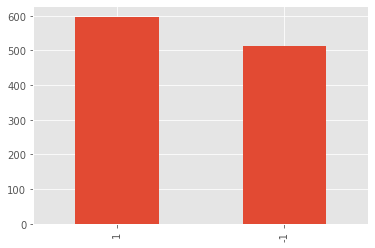

In [51]:
#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")

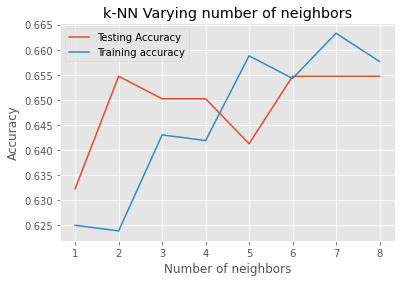

The accuracy score for KNN is: 0.6502242152466368


In [52]:
## KNN 
 
X = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Category','Rise/Fall'],axis=1).values
y = sc_df['Rise/Fall'].values



#Splitting into test and train
X_train,X_test,y_train,y_test = tts(X,y,test_size=0.2,random_state=42, stratify=y)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)
    
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# Fitting the model with k=4
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
    
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test) 

#Accuracy:
print("The accuracy score for KNN is:",test_accuracy)

In [53]:
#Confusion Matrix
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,74,29,103
1,49,71,120
All,123,100,223


In [63]:
# Calculating Measures by hand
TP = 71
FP = 29
FN = 49
TN = 74
recall = TP/(TP+FN)
precision= TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.5916666666666667 
Precision:  0.71 
F Measure:  0.6454545454545454


In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.60      0.72      0.65       103
           1       0.71      0.59      0.65       120

    accuracy                           0.65       223
   macro avg       0.66      0.66      0.65       223
weighted avg       0.66      0.65      0.65       223



In [56]:
## Random Forest Classifier

rfc = RandomForestClassifier()

features=["tot_cases", "case_change", "tot_death", "death_change"]

X = sc_df.loc[:, features]
Y = sc_df["Rise/Fall"]
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size=0.2, random_state=42)

rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

In [57]:
accuracy = metrics.accuracy_score(Y_test, Y_pred)
print("The accuracy score for random forest classifier is:", accuracy)

The accuracy score for random forest classifier is: 0.6233183856502242


In [58]:
pd.crosstab(Y_test, Y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,58,37,95
1,47,81,128
All,105,118,223


In [59]:
TP = 81
FP = 37
FN = 47
TN = 58
recall = TP/(TP+FN)
precision = TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.6328125 
Precision:  0.6864406779661016 
F Measure:  0.6585365853658537


In [60]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.61      0.58        95
           1       0.69      0.63      0.66       128

    accuracy                           0.62       223
   macro avg       0.62      0.62      0.62       223
weighted avg       0.63      0.62      0.63       223



In [61]:
# pairwise correlation of columns
covid_stocks_dummies = pd.concat([sc_df, pd.get_dummies(sc_df["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

,Adj Close,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_it,Dummy_pharmacy,Dummy_retail,Dummy_utility
Adj Close,1.000000,0.103548,0.035759,0.023957,0.035688,0.029591,-0.002093,-0.002414,-0.140196,-0.028175,-0.117735,-0.082490,-0.087403,0.476625,-0.037808
stock_price_change,0.103548,1.000000,0.005629,0.018243,0.006596,0.020469,0.000749,0.000236,0.000491,0.001751,-0.000615,-0.001649,-0.000094,-0.000722,0.001578
tot_cases,0.035759,0.005629,1.000000,0.441564,0.988258,0.640034,0.171644,0.179409,-0.006088,-0.004891,-0.008256,-0.006116,-0.008256,0.035658,-0.004891
new_case,0.023957,0.018243,0.441564,1.000000,0.397790,0.711025,0.281288,0.188761,-0.004498,-0.003994,-0.006742,-0.004995,-0.006742,0.028624,-0.003994
tot_death,0.035688,0.006596,0.988258,0.397790,1.000000,0.589888,0.169029,0.180491,-0.005584,-0.004692,-0.007920,-0.005868,-0.007920,0.033941,-0.004692
new_death,0.029591,0.020469,0.640034,0.711025,0.589888,1.000000,0.325312,0.320834,-0.003713,-0.003963,-0.006689,-0.004956,-0.006689,0.027620,-0.003963
case_change,-0.002093,0.000749,0.171644,0.281288,0.169029,0.325312,1.000000,0.991587,0.000248,0.000112,0.000190,0.000140,0.000190,-0.000931,0.000112
death_change,-0.002414,0.000236,0.179409,0.188761,0.180491,0.320834,0.991587,1.000000,0.000568,0.000303,0.000512,0.000379,0.000512,-0.002409,0.000303
Dummy_biotech,-0.140196,0.000491,-0.006088,-0.004498,-0.005584,-0.003713,0.000248,0.000568,1.000000,-0.137665,-0.232390,-0.172162,-0.232390,-0.217244,-0.137665
Dummy_consumer,-0.028175,0.001751,-0.004891,-0.003994,-0.004692,-0.003963,0.000112,0.000303,-0.137665,1.000000,-0.138071,-0.102287,-0.138071,-0.129072,-0.081792


In [64]:

finalVars = ["Rise/Fall","stock_price_change",
             "death_change","case_change",
             "Dummy_biotech", "Dummy_consumer",
             "Dummy_energy", "Dummy_it","Dummy_pharmacy",
             "Dummy_retail", "Dummy_utility"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()

,stock_price_change,death_change,case_change,Dummy_biotech,Dummy_consumer,Dummy_energy,Dummy_it,Dummy_pharmacy,Dummy_retail,Dummy_utility
stock_price_change,1.000000,0.000236,0.000749,0.000491,0.001751,-0.000615,-0.001649,-0.000094,-0.000722,0.001578
death_change,0.000236,1.000000,0.991587,0.000568,0.000303,0.000512,0.000379,0.000512,-0.002409,0.000303
case_change,0.000749,0.991587,1.000000,0.000248,0.000112,0.000190,0.000140,0.000190,-0.000931,0.000112
Dummy_biotech,0.000491,0.000568,0.000248,1.000000,-0.137665,-0.232390,-0.172162,-0.232390,-0.217244,-0.137665
Dummy_consumer,0.001751,0.000303,0.000112,-0.137665,1.000000,-0.138071,-0.102287,-0.138071,-0.129072,-0.081792
Dummy_energy,-0.000615,0.000512,0.000190,-0.232390,-0.138071,1.000000,-0.172669,-0.233074,-0.217884,-0.138071
Dummy_it,-0.001649,0.000379,0.000140,-0.172162,-0.102287,-0.172669,1.000000,-0.172669,-0.161415,-0.102287
Dummy_pharmacy,-0.000094,0.000512,0.000190,-0.232390,-0.138071,-0.233074,-0.172669,1.000000,-0.217884,-0.138071
Dummy_retail,-0.000722,-0.002409,-0.000931,-0.217244,-0.129072,-0.217884,-0.161415,-0.217884,1.000000,-0.129072
Dummy_utility,0.001578,0.000303,0.000112,-0.137665,-0.081792,-0.138071,-0.102287,-0.138071,-0.129072,1.000000


/Users/emma/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emma/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emma/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emma/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emma/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emma/opt/anaconda3/lib/pytho

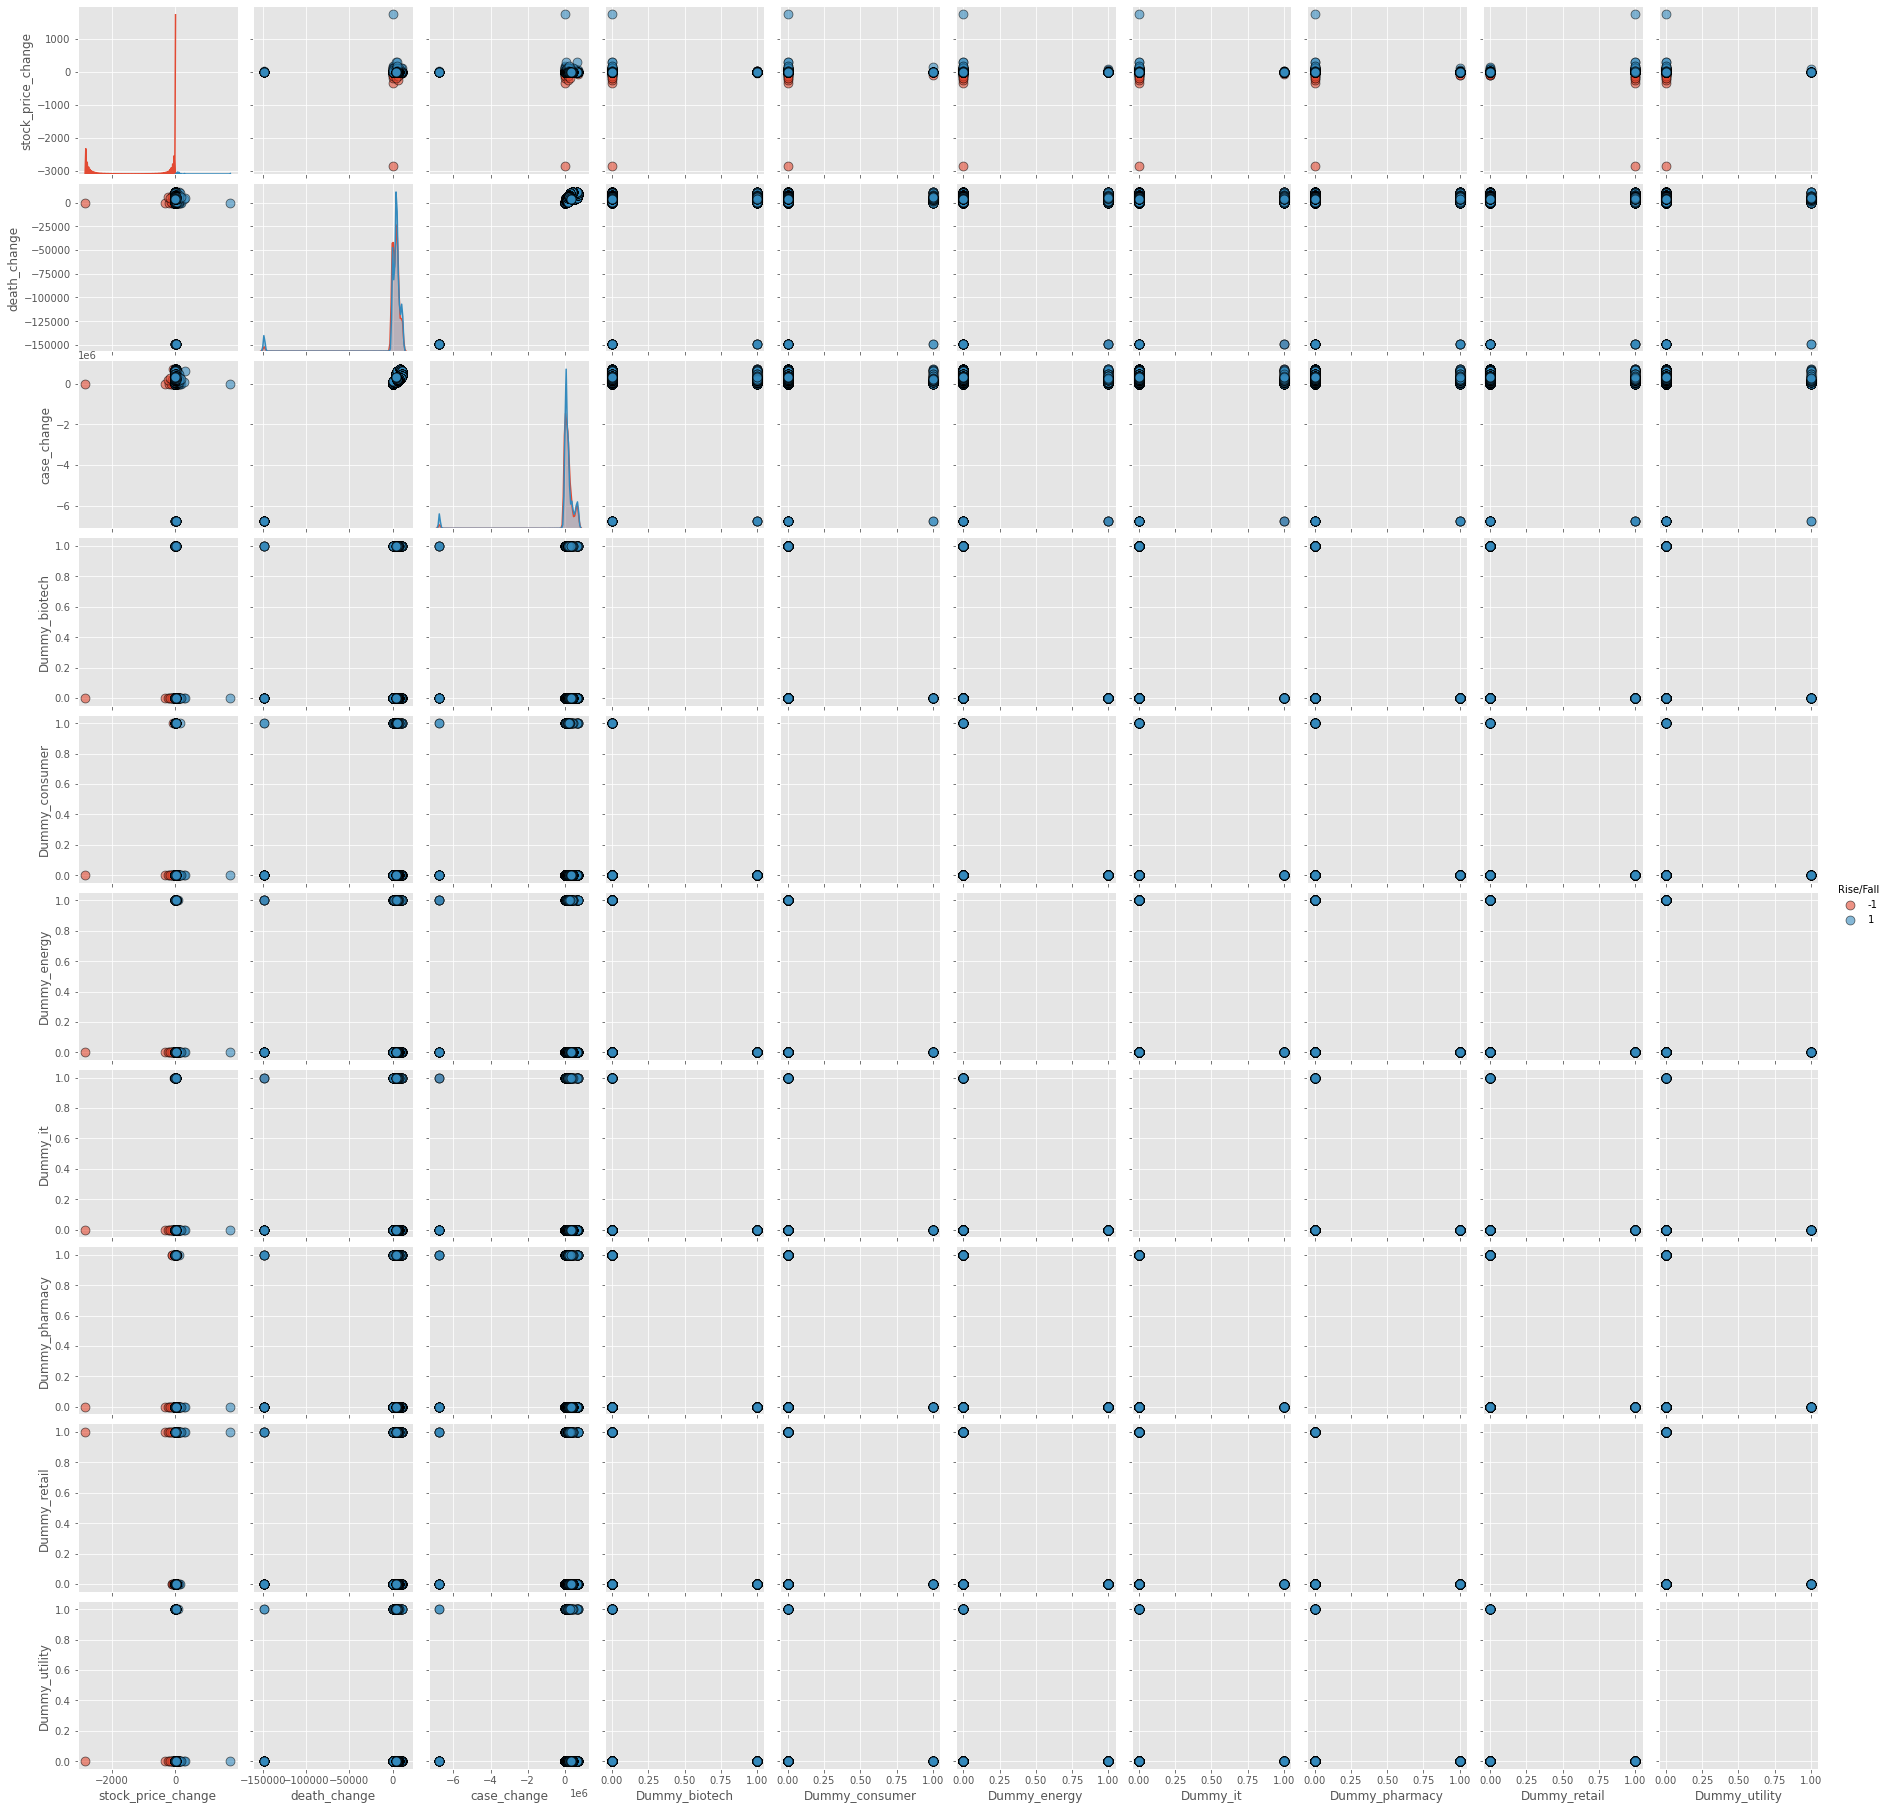

In [65]:
sns.pairplot(final, hue = "Rise/Fall", diag_kind = "kde", plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})